In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from matplotlib.patches import ConnectionPatch
import seaborn as sns

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

%matplotlib inline

# Rotating single vector

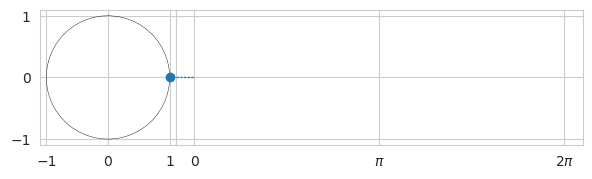

In [13]:
with sns.axes_style('whitegrid'):
    fig, (axl, axr) = plt.subplots(
        ncols=2,
        sharey=True,
        figsize=(7, 3),
        gridspec_kw=dict(width_ratios=[1, 3], wspace=0),
    )
    axl.set_aspect(1)
    axr.set_box_aspect(1 / 3)
    axr.xaxis.set_ticks([0, np.pi, 2 * np.pi], ["0", r"$\pi$", r"$2\pi$"])

# draw circle with initial point in left Axes
x = np.linspace(0, 2 * np.pi, 50)
axl.plot(np.cos(x), np.sin(x), "black", lw=0.3)
point, = axl.plot(0, 0, "o")

# draw full curve to set view limits in right Axes
sine, = axr.plot(x, np.sin(x))

# draw connecting line between both graphs
con = ConnectionPatch(
    (1, 0),
    (0, 0),
    "data",
    "data",
    axesA=axl,
    axesB=axr,
    color="C0",
    ls="dotted",
)
fig.add_artist(con)


def animate(i):
    x = np.linspace(0, i, int(i * 25 / np.pi))
    sine.set_data(x, np.sin(x))
    x, y = np.cos(i), np.sin(i)
    point.set_data([x], [y])
    con.xy1 = x, y
    con.xy2 = i, y
    return point, sine, con


ani = FuncAnimation(
    fig,
    animate,
    interval=50,
    blit=False,  # blitting can't be used with Figure artists
    frames=x,
    repeat_delay=100,
)

In [3]:
ani

In [4]:
ani.save('../../assets/images/optimization/rotation_and_sinusoid.gif');

# Step-function approximation

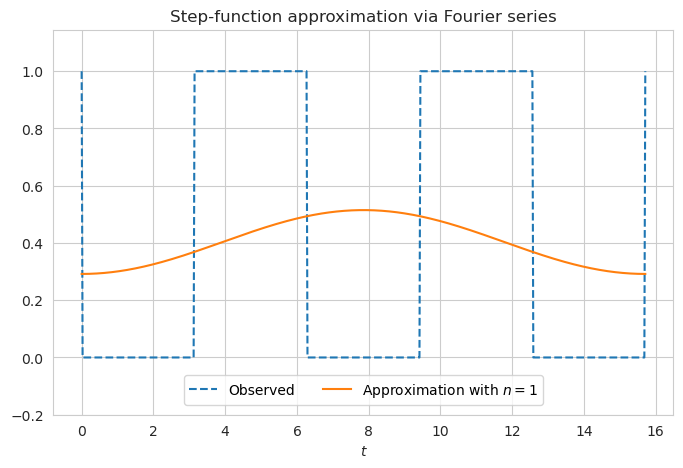

In [6]:
def step_function(x, period=2*np.pi, origin=0):
    length_from_origin = abs(x - origin)
    if length_from_origin%period < period/2 and x > 0:
        return 0
    elif length_from_origin%period > period/2 and x < 0:
        return 0
    else:
        return 1


P = 5*np.pi  # period to approximate
t = np.linspace(0, P, 600)  # range of t


observed_values = [step_function(element) for element in t]


def fourier_series(t,
                   obs_vals,
                   period=P, n=5):

    def get_c_coef(n):
        """Get Riemann sum instead of the integral in order to approximate."""
        ind_c_elements = np.array(obs_vals) * np.exp(-1j*2*np.pi*n*t/period)
        return ind_c_elements.sum()/ind_c_elements.size

    if isinstance(n, int):
        nth_series = np.array([get_c_coef(i)*np.exp(1j*2*np.pi*i*t/period) for i in range(1, n+1)])
    elif isinstance(n, list) or isinstance(n, np.ndarray):
        nth_series = np.array([get_c_coef(i)*np.exp(1j*2*np.pi*i*t/period) for i in n])
    fourier_series = nth_series.sum(axis=0)
        
    return fourier_series

fourier_series_init = fourier_series(t, observed_values, n=np.arange(-50,51)).real

with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize=(8, 5))

line_observed, = ax.plot(t, observed_values, linestyle='--', label='Observed')
line_approximated, = ax.plot(t, fourier_series_init, label='Approximation')
ax.set_xlabel('$t$')
ax.set_title('Step-function approximation via Fourier series')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.12),
          fancybox=True, ncols=2)
ax.set_ylim(bottom=-0.2)


def animate(i):
    fourier_series_current = fourier_series(t, observed_values, n=np.arange(-i,i)).real
    line_approximated.set_data(t, fourier_series_current)
    ax.get_legend().texts[1].set_text(f'Approximation with $n=${i}')
    return line_approximated,


ani = FuncAnimation(
    fig,
    animate,
    interval=200,
    blit=True,  # blitting can't be used with Figure artists
    frames=range(1, 36, 1),
    repeat_delay=100,
)

In [7]:
ani

In [8]:
ani.save('../../assets/images/optimization/step_function_approximation_fourier.gif');

# Rotating arrows in complex space

## Getting coordinates from the image Bazier curves

In [2]:
import re

In [3]:
svg_path_data = """M446.161,119.933c-0.544-0.173-1.151,0.051-1.711,0.078c-1.017,0.132-2.463,0.329-3.887,0.581
			c-5.072,0.826-10.106,1.905-14.989,3.521c-4.299,1.478-8.635,2.878-12.822,4.658c-8.551,3.577-17.061,7.556-24.538,13.084
			c-0.371,0.002-0.716,0.008-0.992-0.01c-2.414,0.01-4.819,0.2-7.221,0.425c-4.095,0.356-6.922,0.703-12.117-0.728
			c-4.168-1.148-16.314-11.982-42.391,3.802c-2.198,1.33-4.191,2.968-6.142,4.635c-6.968,5.607-11.661,12.869-13.964,21.513
			c-0.075,0.282-0.142,0.566-0.212,0.849c-0.014-0.777-0.087-1.555-0.176-2.316c-0.619-4.142-2.606-7.909-4.669-11.499
			c-1.581-2.813-3.236-5.585-4.74-8.44c-2.597-4.945-5.022-9.979-7.527-14.972c-2.485-4.985-4.909-10-7.282-15.039
			c-1.6-3.293-2.919-6.091-4.167-9.217c-3.286-8.256-6.208-16.653-9.16-25.032c-2.257-7.089-4.883-14.047-7.455-21.025
			c-1.64-4.476-3.242-8.966-4.75-13.489c-1.099-3.242-2.083-6.537-3.575-9.627c-0.474-0.977-1.047-1.906-1.722-2.758
			c-0.382-0.467-0.745-0.978-1.272-1.29c-1.027-0.491-2.188,0.24-2.516,1.274c-0.481,1.172-0.57,2.455-0.698,3.703
			c-0.129,1.724-0.167,3.454-0.203,5.182c-0.1,5.464-0.03,10.944,0.596,16.378c0.672,5.257,1.454,10.523,2.79,15.658
			c0.216,0.76,0.443,1.518,0.677,2.273c-1.831,0.114-2.345,3.573-2.493,6.181c-0.154,4.297,0.428,8.583,0.895,12.846
			c0.673,5.869,1.618,11.705,2.811,17.491c0.982,4.559,1.855,9.148,3.148,13.632c1.769,6.005,3.769,12.058,6.245,17.809
			c1.457,3.255,3.275,6.331,4.746,9.578c0.212,0.483,0.379,0.825,0.523,1.144c-0.108-0.085-0.234-0.184-0.395-0.308
			c-0.585-0.426-1.117-0.999-1.825-1.208c-1.927-0.176-1.83,2.555-1.711,3.869c0.681,4.887,2.615,9.523,4.742,13.942
			c2.156,4.352,4.512,8.605,6.984,12.785c5.702,9.638,9.008,10.747,9.377,11.288c-2.989-2.058-5.974-4.121-9.023-6.09
			c-4.782-3.152-9.497-6.417-14.537-9.151c-5.41-3.131-11.256-5.365-16.965-7.872c-5.231-2.415-10.207-5.332-15.295-8.025
			c-3.828-2.021-7.666-4.024-11.482-6.066c-0.097-0.06-0.208-0.084-0.32-0.083c-1.604-0.896-3.232-1.748-4.924-2.466
			c-0.834-0.346-1.675-0.671-2.52-0.988c-0.213-0.147-0.426-0.294-0.639-0.44c-4.001-2.816-7.99-5.652-12.12-8.279
			c-4.755-3.017-9.601-5.887-14.307-8.981c-17.686-11.691-36.115-22.209-54.836-32.144c-11.982-6.328-24.062-12.484-36.427-18.033
			c-6.695-3.035-13.366-6.138-20.235-8.765c-6.403-2.435-11.942-4.804-17.69-7.311c-2.444-1.093-4.928-2.089-7.464-2.946
			c-0.631-0.215-1.256-0.457-1.916-0.569c-0.543-0.118-1.171,0.038-1.442,0.569c-0.295,0.746,0.174,1.487,0.438,2.174
			c0.567,1.332,1.391,2.529,2.135,3.766c3.438,5.521,7.535,10.626,12.253,15.105c7.056,6.75,14.9,12.71,23.298,17.692
			c0.548,0.315,1.098,0.625,1.65,0.931c-3.878-1.18-7.791-2.268-11.802-2.893c-1.977-0.296-3.974-0.705-5.979-0.566
			c-0.979,0.109-1.973,0.264-2.871,0.685c-0.479,0.226-0.927,0.561-1.12,1.072c-0.421,0.966-0.354,2.059-0.249,3.084
			c0.143,1.564,0.539,3.092,1.056,4.571c1.246,3.713,3.047,8.118,4.404,11.178c2.255,5.339,4.938,10.497,8.204,15.29
			c4.557,6.965,11.409,12.968,15.766,19.352c5.49,8.075,8.084,15.78,11.762,24.392c2.35,5.284,5.094,10.402,8.19,15.286
			c4.146,6.422,9.517,11.914,15.242,16.937c5.22,4.665,10.71,9.019,16.491,12.97c7.565,5.271,15.881,9.324,24.384,12.84
			c6.947,3.068,14.036,5.788,21.238,8.196c3.64,1.271,7.253,2.617,10.875,3.938c5.557,2.01,10.399,3.863,15.708,6.856
			c4.249,2.412,8.266,5.274,12.885,6.966c2.581,0.945,9.496,3.763,21.012-0.533c-3.37,3.587-6.631,7.279-9.794,11.048
			c-6.196,7.706-12.109,15.641-17.831,23.705c-4.555,6.322-8.685,12.931-13.031,19.393c-0.958,1.424-8.957,12.702-13.38,17.633
			c-1.632,1.82-9.928,11.969-13.288,15.977c-5.645,6.733-11.387,13.385-16.958,20.179c-9.958,12.279-19.493,24.997-27.276,38.785
			c-4.559,8.122-8.536,16.588-11.5,25.426c-0.98,3.158-1.875,6.348-2.531,9.59c-0.216,1.105-0.388,2.217-0.51,3.336
			c-0.077,0.923-0.231,1.896,0.139,2.772c0.381,1.044,1.558,1.658,2.638,1.424c1.448-0.297,2.538-1.427,3.515-2.465
			c2.228-2.5,3.938-5.4,5.722-8.22c1.328-2.132,2.62-4.285,3.899-6.447c0.366-0.124,0.717-0.303,1.048-0.491
			c0.976-0.578,1.838-1.322,2.662-2.097c3.07-2.882,5.734-6.15,8.425-9.379c4.393-5.209,8.701-10.489,13.245-15.568
			c1.76-1.989,3.541-3.958,5.332-5.919c-0.354,0.645-0.694,1.296-1.006,1.962c-0.347,0.84-0.866,1.677-0.778,2.616
			c0.505,2.057,2.705,1.485,4.061,0.608c2.882-1.842,5.221-4.378,7.577-6.827c2.74-2.884,5.37-5.871,8.034-8.825
			c7.384-7.963,14.866-15.871,23.08-22.99c8.644-7.294,17.443-13.883,27.109-20.166c6.139-4.146,31.221-17.756,31.19-25.577
			c6.155-2.433,16.924-5.583,18.184,2.431c0.023,0.145,0.04,0.291,0.054,0.439c-4.329,2.862-8.783,5.65-11.933,9.839
			c-0.77,0.996-1.472,2.055-1.975,3.213c-0.321,0.705-0.622,1.457-0.551,2.247c0.36,3.409,4.26,1.684,6.127,0.616
			c1.673-0.956,3.085-2.293,4.433-3.654c2.869-3.01,5.301-7.57,5.159-11.836c3.219-2.18,6.396-4.469,8.92-7.349
			c1.504-0.559,2.928-1.404,4.327-2.149c18.527-9.874,26.664-5.109,27.97-4.577c-3.252,1.032-6.417,2.335-9.454,3.905
			c-5.471,2.718-10.725,6.199-14.534,11.045c-3.132,4.008-6.825,11.422-3.818,16.255c0.584,0.852,1.243,1.674,2.079,2.291
			c1.072,0.763,2.336,1.258,3.613,1.552c5.804,1.121,14.735-2.722,19.643-5.828c4.522-3.257,9.255-6.909,11.442-12.205
			c4.583-11.096-4.398-15.961-5.811-16.775c1.577-0.419,3.183-0.785,4.815-1.096c5.385-1.083,10.301-1.674,15.929-1.754
			c5.77-0.031,10.917,0.297,16.35,2.012c2.703,0.882,5.137,2.159,7.792,3.771c2.319,1.462,4.26,3.264,6.216,5.547
			c1.873,2.444,3.505,5.93,4.086,9.462c0.738,4.046,0.053,8.723-1.619,13.103c-0.828,2.131-3.088,6.045-4.577,7.808
			c-1.848,2.344-4.022,4.398-6.11,6.523c-0.498,0.492-0.996,0.985-1.496,1.475c-0.158,0.137-0.3,0.312-0.292,0.533
			c-0.016,0.374,0.388,0.676,0.746,0.568c0.302-0.099,0.48-0.399,0.72-0.592c0.703-0.676,1.401-1.357,2.092-2.044
			c3.12-3.02,6.167-6.195,8.263-10.034c3.814-6.594,5.186-14.951,2.158-22.11c-2.841-7.426-9.911-12.224-17.135-14.863
			c-6.419-2.166-13.312-2.421-20.029-2.153c-4.778,0.22-9.53,0.883-14.211,1.856c-1.736,0.337-3.456,0.749-5.154,1.234
			c-13.353-6.243-27.036,2.247-32.527,5.416c0.564-0.753,1.09-1.533,1.551-2.354c0.383-0.722,0.826-1.437,0.961-2.256
			c0.549-2.325-1.812-3.119-3.682-2.57c-1.85,0.558-3.462,1.714-4.793,3.093c-0.689,0.744-1.452,1.477-1.863,2.421
			c-1.024,2.478,0.81,4.057,3.205,4.11c0.422,0.001,0.836-0.039,1.243-0.104c-1.786,1.799-3.419,3.037-5.492,4.522
			c-0.539,0.38-1.086,0.752-1.637,1.122c-0.496-3.762-3.765-10.029-19.604-3.2c-1.194-2.935-4.915-3.6-7.774-3.871
			c-3.083-0.288-6.21-0.23-9.275,0.221c-7.657,1.351-14.934,4.545-21.338,8.922c-6.086,4.168-11.392,9.365-16.482,14.676
			c-1.898,2.063-12.048,12.417-9.364,14.966c1.066,1.043,2.761,0.893,4.087,0.505c2.696-0.736,5.116-2.198,7.393-3.781
			c1.792-1.292,3.544-2.639,5.223-4.073c1.173,0.629,2.767,0.73,4.098,0.326c2.086-0.512,4.003-1.521,5.91-2.48
			c3.097-1.595,5.971-3.581,8.79-5.618c6.043-4.286,11.95-8.775,18.187-12.778c3.173-2.061,6.324-3.91,9.607-5.409
			c-0.384,2.624-3.915,5.802-6.664,8.105c-7.174,6.001-16.296,11.064-24.541,16.361c-9.088,5.929-17.803,12.442-26.114,19.417
			c-8.329,7.123-15.855,15.113-23.318,23.122c-3.006,3.334-5.965,6.712-9.074,9.951c-1.883,1.958-3.777,3.931-5.999,5.509
			c-1.152,0.748-2.032,1.281-2.748,1.043c0.001-0.008-0.06-0.047-0.111-0.076c-0.039-0.044-0.084-0.086-0.109-0.104
			c-0.038-0.057-0.068-0.101-0.07-0.09c-0.013-0.035-0.024-0.063-0.031-0.078c-0.034-0.672,0.239-0.952,0.602-1.868
			c0.701-1.521,1.553-2.966,2.395-4.412c0.387-0.675,0.783-1.344,1.182-2.011c2.653-2.87,5.319-5.729,7.973-8.598
			c4.679-5.107,9.265-10.297,13.845-15.493c2.812-3.176,5.507-6.452,8.039-9.857c1.223-1.712,2.751-3.429,3.669-5.313
			c0.291-0.673-0.237-1.401-0.967-1.363c-1.742,0.13-3.411,1.73-4.868,2.888c-3.308,2.995-6.46,6.177-9.304,9.618
			c-3.334,4.078-6.349,8.401-9.432,12.668c-3.514,4.785-6.815,9.726-9.876,14.813c-2.973,3.218-5.929,6.451-8.829,9.735
			c-4.52,5.058-8.792,10.327-13.159,15.515c-2.664,3.213-5.311,6.458-8.363,9.316c-0.589,0.548-1.263,1.131-1.917,1.588
			c1.135-1.932,2.264-3.867,3.397-5.799c6.431-11.148,12.789-22.342,19.448-33.357c3.666-6.05,7.611-11.922,11.436-17.871
			c0.786-1.251,1.55-2.516,2.292-3.794c0.535-0.962,1.171-1.883,1.518-2.935c0.428-1.523-0.964-1.579-1.913-0.857
			c-1.199,0.801-2.143,1.906-3.098,2.971c-1.241,1.429-2.434,2.898-3.599,4.39c-8.411,10.618-16.07,21.823-23.048,33.431
			c-2.74,4.666-5.26,9.463-7.41,14.431c-1.115,2.774-2.505,5.518-2.882,8.512c-0.229,1.095,0.277,2.415,1.396,2.729
			c-1.335,2.243-2.688,4.477-4.077,6.687c-2.154,3.347-4.645,7.54-7.213,8.898c-0.209,0.096-0.427,0.172-0.654,0.211
			c-0.065,0.005-0.13,0.008-0.196,0.006c-0.062,0.003-0.123,0.001-0.185-0.004c-0.068-0.017-0.135-0.035-0.203-0.053
			c-0.088-0.041-0.174-0.088-0.254-0.144c-0.053-0.045-0.117-0.103-0.165-0.153c-0.04-0.074-0.11-0.195-0.153-0.266
			c-0.231-0.631-0.115-1.261-0.032-2.22c0.149-1.812,0.876-5.021,1.611-7.745c2.409-8.989,5.837-16.777,10.002-24.857
			c8.271-15.97,19.247-30.625,29.892-43.841c5.462-6.707,10.563-12.865,16.034-19.271c24.563-28.76,29.115-36.456,35.015-46.004
			c5.605-8.259,11.516-16.306,17.581-24.233c5.047-6.713,11.246-13.898,17.581-20.469c2.279-1.028,4.702-2.346,7.314-3.951
			c1.968-1.209,10.289-6.215,16.874-14.283c0.74-1.003,4.813-5.726,2.452-6.045c-0.36-0.021-0.653,0.206-0.943,0.388
			c-0.457,0.284-0.901,0.588-1.343,0.893c-1.662,1.16-3.282,2.378-4.884,3.62c-4.565,3.538-8.923,7.336-13.137,11.284
			c-2.405,2.256-4.747,4.576-7.04,6.946c-17.019,7.567-27.013-0.284-33.737-4.373c-3.102-1.887-6.381-3.438-9.718-4.86
			c-5.371-2.271-10.917-4.107-16.379-6.147c-5.907-2.037-13.291-4.626-18.363-6.812c-6.695-2.858-13.455-5.602-19.84-9.118
			c-6.743-3.654-13.166-8.258-18.755-12.658c-6.449-5.21-13.812-11.694-18.542-17.658c-4.2-5.325-7.464-11.306-10.462-17.369
			c-1.917-4.034-3.552-8.439-5.509-12.926c-2.594-6.065-5.623-12.012-9.74-17.197c-3.348-4.169-7.153-7.947-10.492-12.124
			c-3.377-4.222-6.888-9.811-9.425-15.206c-2.01-4.45-3.831-8.312-5.391-12.71c-1.111-2.833-2.138-6.356-1.915-8.508
			c0.159-1.288,0.551-1.188,1.959-1.59c1.675-0.424,3.849-0.079,5.554,0.171c2.035,0.319,4.063,0.697,6.068,1.169
			c4.774,1.207,9.471,2.684,14.132,4.268c14.441,7.07,29.866,11.993,45.026,17.293c5.932,2.201,11.694,4.891,17.63,7.93
			c6.494,3.446,12.835,7.172,19.261,10.742c4.395,2.447,8.913,4.735,13.704,6.304c0.441,0.117,0.924,0.221,1.354,0.023
			c0.286-0.199,0.479-0.607,0.294-0.934c-0.512-0.921-1.564-1.396-2.37-2.032c-9.434-6.386-19.584-11.663-29.975-16.307
			c-8.665-3.716-17.572-6.822-26.384-10.164c-7.068-2.563-14.043-5.371-21.068-8.047c-5.618-2.033-11.233-4.09-16.897-5.997
			c-2.53-1.242-5.056-2.561-7.591-3.98c-5.377-2.998-11.337-7.352-15.656-10.74c-4.779-3.804-9.29-7.951-13.382-12.489
			c-2.905-3.442-5.399-6.872-7.858-10.977c-0.623-1.076-1.27-2.088-1.563-3.225c0.023,0.003,0.046,0.002,0.069,0.006
			c4.846,1.403,10.414,4.13,15.748,6.409c5.164,2.23,11.832,4.726,16.417,6.616c7.274,3.103,14.444,6.445,21.629,9.747
			c9.155,4.255,18.11,8.929,27.072,13.572c13.36,7.066,26.584,14.398,39.498,22.253c6.618,3.925,12.999,8.224,19.472,12.379
			c5.605,3.638,11.415,6.954,16.934,10.725c1.239,0.852,2.475,1.708,3.712,2.563c-0.558-0.214-1.114-0.431-1.667-0.659
			c-2.239-0.902-4.454-1.871-6.735-2.665c-0.67-0.198-1.36-0.565-2.076-0.465c-1.645,0.787-0.472,3.212,0.121,4.394
			c2.509,4.444,6.408,7.91,10.385,11.022c4.392,3.493,9.261,6.433,14.644,8.105c2.161,0.679,9.932,2.982,8.816-0.69
			c-1.575-3.8-4.722-6.697-7.793-9.322c-1.538-1.33-3.139-2.579-4.772-3.787c0.983,0.533,1.948,1.097,2.918,1.654
			c0.132,0.077,0.286,0.103,0.435,0.083c2.583,1.488,5.212,2.895,7.844,4.294c5.503,2.868,10.841,6.058,16.458,8.705
			c5.572,2.541,11.336,4.684,16.669,7.726c5.387,2.909,10.423,6.388,15.513,9.775c5.096,3.289,9.984,6.891,15.052,10.221
			c0.364,0.43,0.809,0.808,1.079,1.302c7.813,14.324,12.31,12.923,12.46,10.675c0.171-0.919-0.144-1.848-0.413-2.719
			c-0.572-1.699-1.682-3.13-3.029-4.292c-1.221-1.154-2.579-2.146-3.997-3.044c-1.976-1.201-3.915-2.457-5.837-3.738
			c-0.889-0.592-7.921-5.887-14.001-16.175c-2.348-3.973-4.615-7.997-6.699-12.114c-2.324-4.572-5.632-12.689-4.7-16.089
			c0.039-0.046,0.073-0.082,0.098-0.108c0.651,0.305,1.626,1.376,2.777,2.028c0.545,0.324,1.345,0.089,1.363-0.617
			c-0.03-0.925-0.612-1.755-0.924-2.612c-1.569-3.637-3.61-7.048-5.163-10.693c-2.173-5.352-4.65-12.476-6.327-18.685
			c-2.477-10.034-4.561-20.488-5.693-30.262c-0.473-4.767-1.815-13.03,0.348-16.368c0.154-0.112,0.326-0.147,0.558-0.067
			c1.683,5.214,3.764,10.302,6.069,15.267c1,2.131,2.048,4.24,3.12,6.336c0.958,1.919,2.011,3.804,3.405,5.444
			c0.736,0.998,1.741,1.491,2.537,0.272c0.378-0.654,0.207-1.47,0.018-2.161c-0.726-2.273-1.799-4.419-2.747-6.605
			c-1.763-3.974-3.676-7.881-5.747-11.704c-1.216-2.219-2.371-4.54-4.195-6.331c-0.516-0.542-0.982-0.937-1.404-1.207
			c-1.087-3.459-1.915-6.996-2.51-10.577c-0.585-3.614-1.111-6.755-1.407-10.133c-0.406-4.512-0.467-9.049-0.4-13.576
			c0.02-3.511,0.205-9.164,1.376-9.58c0.065-0.005,0.131-0.009,0.196-0.014c0.035,0.007,0.069,0.019,0.103,0.03l0.043,0.026
			c0.109,0.091,0.21,0.191,0.304,0.298c0.643,0.738,0.899,1.082,1.489,2.039c1.404,2.457,2.266,5.131,3.258,8.1
			c1.185,3.564,2.373,7.127,3.639,10.663c2.106,5.962,4.357,11.87,6.489,17.822c1.819,5.33,3.512,10.703,5.466,15.987
			c1.863,5.131,3.636,10.295,5.638,15.375c1.578,4.103,3.395,8.104,5.33,12.049c2.215,4.706,4.48,9.388,6.795,14.046
			c2.763,5.496,5.414,11.049,8.307,16.478c1.881,3.524,3.999,6.916,5.895,10.431c1.948,3.439,2.688,6.255,3.123,11.522
			c0.398,6.445,2.126,0.514,2.639-1.45c1.297-4.851,3.073-8.95,6.015-13.2c1.883-2.768,4.692-5.617,7.597-8.039
			c3.526-3.176,7.611-5.773,12.212-7.901c22.793-10.546,29.267-1.539,37.398,0.117c5.667,1.154,11.399-0.211,17.111-0.2
			c-0.115,0.09-0.233,0.176-0.348,0.267c-1.473,1.111-2.659,2.521-3.897,3.874c-0.184,0.099-1.32,0.667-1.647,0.887
			c-0.257,0.173-0.507,0.357-0.76,0.536c-0.197,0.127-0.39,0.254-0.578,0.38c-0.069,0.042-0.136,0.086-0.207,0.125
			c-0.742,0.385-1.536,0.658-2.322,0.939c-2.264,0.823-4.964,1.424-6.926,1.615c-3.914,0.508-8.219,0.49-11.793,2.267
			c-0.771-0.054-1.547,0.003-2.312,0.128c-1.077,0.166-2.049,0.643-3.008,1.122c-0.335-0.501-0.728-0.962-1.182-1.362
			c-1.593-1.244-3.802-1.706-5.906-1.485c-0.027,0-0.054-0.003-0.081-0.002c-0.635,0.02-1.259,0.18-1.857,0.413
			c-0.633,0.208-1.232,0.482-1.772,0.823c-1.663,1.101-3.167,2.621-3.665,4.606c-0.302,1.027-0.32,2.113-0.263,3.174
			c0.089,1.45,0.476,2.921,1.455,4.032c0.594,0.658,1.325,1.145,2.135,1.479c-0.592-0.044-1.199-0.096-1.828-0.143
			c-2.086-0.11-4.189,0.033-6.251,0.358c-3.23,0.589-6.316,1.935-9.09,3.673c-3.197,2.097-5.684,5.215-7.081,8.77
			c-1.15,3.068-1.629,8.295,0.541,10.955c2.804,3.937,8.018,5.417,12.636,5.711c3.296,0.018,6.701-0.191,9.783-1.448
			c5.336-2.055,9.991-5.47,14.425-9.018c2.261-1.877,4.377-3.921,6.634-5.803c5.145-4.166,10.476-8.138,15.421-12.544
			c-0.602,1.697-1.227,3.335-1.797,4.614c-2.774,6.412-5.648,12.863-7.727,19.539c-1.924,6.859-3.109,13.982-3.003,21.119
			c0.052,3.136,0.088,6.272,0.188,9.407c0.096,2.818,0.28,5.637,0.231,8.458c-0.129,4.047-0.727,7.326-1.664,11.403
			c-1.042,4.716-2.605,9.293-4.494,13.734c-1.962,4.895-4.843,10.564-7.944,15.469c-5.641,9.398-12.127,17.733-19.487,25.746
			c-2.281,0.601-4.526,1.322-6.7,2.258c-4.708,1.854-9.19,4.432-12.797,8.015c-1.984,1.921-5.686,7.225-2.54,9.442
			c3.317,2.336,16.425-12.178,22.598-18.699c5.132-1.294,10.375-2.093,15.527-3.305c3.697-0.871,7.331-2.039,10.834-3.51
			c4.402-1.905,8.353-4.709,12.073-7.707c2.625-2.203,5.167-4.524,7.485-7.05c1.738-1.892,3.257-3.965,4.814-6.005
			c2.213-3.252,4.394-6.582,5.74-10.303c0.352-1.004,0.704-2.02,0.853-3.078c0.162-1.156,0.103-2.33-0.027-3.486
			c-0.047-0.405-0.104-0.809-0.171-1.211c-0.015-0.266-0.235-0.513-0.503-0.531c-0.429-0.08-0.769,0.387-0.63,0.783
			c0.008,0.071,0.03,0.221,0.043,0.299c0.103,0.843,0.176,1.692,0.169,2.542c0.059,1.685-0.54,3.308-1.272,5.167
			c-1.026,2.587-3.291,6.253-5.191,9.028c-1.635,2.132-2.708,3.637-4.418,5.56c-1.977,2.253-4.178,4.297-6.408,6.296
			c-4.34,3.797-9.681,7.552-15.009,9.483c-4.87,1.883-9.969,3.024-15.086,4.001c-2.478,0.477-4.968,0.948-7.429,1.526
			c7.342-8.078,13.986-16.813,19.517-26.232c2.63-4.243,4.857-8.715,6.794-13.314c1.81-4.177,3.43-8.445,4.515-12.873
			c1.052-4.189,1.905-8.439,2.142-12.76c0.101-2.999-0.084-5.999-0.18-8.996c-0.087-3.199-0.137-6.398-0.201-9.597
			c-0.071-4.584,0.283-8.432,1.08-12.706c0.478-2.773,1.059-5.531,1.867-8.228c0.855-2.953,2.012-5.806,3.126-8.668
			c1.549-3.968,2.94-7.23,4.564-11.007c0.833-2.068,1.678-4.163,2.353-6.295c0.884-0.827,1.755-1.668,2.605-2.533
			c1.104-1.152,2.329-2.278,2.942-3.779c0.955-0.178,1.838-0.666,2.679-1.136c1.121-0.635,2.019-1.575,3.03-2.362
			c1.613-1.291,3.259-2.541,5.24-3.992c4.06-2.943,8.329-5.582,12.508-8.352c5.696-3.651,11.666-6.84,17.578-10.12
			c3.234-1.873,6.351-3.947,9.632-5.739c2.453-1.308,4.902-2.623,7.315-4.005c1.316-0.812,2.761-1.476,3.921-2.504
			C446.691,120.695,446.585,120.092,446.161,119.933z M330.095,323.939c6.088,5.084,5.98,12.078,1.021,18.248
			c-1.148,1.429-2.51,2.67-3.881,3.881c-2.685,2.31-5.139,4.122-8.503,5.768c-2.805,1.253-5.179,2.34-8.391,3.074
			c-2.622,0.603-4.804,0.967-7.228,0.262c-1.489-0.491-2.527-0.966-3.646-2.355c-0.549-0.7-1.222-1.683-1.396-2.992
			c-0.618-4.919,2.693-10.985,6.531-14.905c3.752-3.868,8.112-6.517,13.11-8.975c2.999-1.52,6.193-2.759,9.532-3.742
			C328.308,322.732,329.281,323.324,330.095,323.939z M287.853,325.668c0.114-0.99,1.938-2.843,3.064-3.767
			c1.849-1.561,4.674-2.438,5.407-1.122c0.403,1.378-1.772,4.495-3.485,6.52c-0.091,0.035-0.18,0.073-0.272,0.107
			C290.9,328.035,287.512,328.124,287.853,325.668z M277.978,346.993c-2.118,2.227-5.382,4.391-7.425,4.262
			c-0.338-0.031-0.356-0.274-0.501-0.505c-0.415-1.199,0.866-3.258,2.148-5.037c2.715-3.738,6.854-6.479,11.056-9.299
			C283.068,340.052,280.763,344.264,277.978,346.993z M217.22,357.417c-0.296-0.288-0.503-0.643-0.553-1.058
			c-0.075-0.851,0.229-1.6,0.747-2.605c1.261-2.148,3.056-4.062,5.223-5.308c0.923-0.501,1.988-0.787,2.356-0.188
			c-0.035,0.35-1.244,2.155-2.02,3.128C221.495,353.368,219.346,355.54,217.22,357.417z M252.04,338.426
			c-4.796,3.195-9.449,6.597-14.132,9.954c-3.522,2.503-7.004,5.092-10.835,7.112c-2.549,1.253-5.014,2.65-7.46,2.76
			c-0.476,0.033-1.005-0.058-1.484-0.254c2.256-1.972,4.296-4.186,6.102-6.576c0.631-0.94,1.466-1.831,1.768-2.937
			c0.209-1.125-0.91-1.694-1.908-1.586c-3.266,0.29-7.837,5.357-8.443,8.527c-0.196,1.167,0.133,2.063,0.755,2.702
			c-0.796,0.677-1.577,1.302-2.304,1.85c-3.208,2.427-6.375,4.73-10.027,5.642c-2.471,0.616-3.128-0.374-2.707-1.541
			c0.674-1.868,2.477-4.252,3.779-5.918c2.474-3.045,5.203-5.873,7.934-8.686c4.544-4.577,9.114-8.85,14.221-12.285
			c6.372-4.337,14.038-7.548,21.184-8.633c4.415-0.472,13.797-0.826,15.289,3.039c0.004,0.014,0.006,0.028,0.01,0.041
			C259.738,333.487,255.911,335.875,252.04,338.426z M183.936,386.142c3.962-5.557,8.421-10.73,13.684-15.431
			c1.04-0.98,3.081-2.406,3.968-2.576c0.04-0.007,0.083-0.011,0.124-0.012c-0.143,0.348-0.503,0.808-0.807,1.264
			c-0.864,1.237-1.775,2.44-2.683,3.644c-2.5,3.377-5.403,6.896-8.445,10.31c-4.318,4.906-8.653,9.797-13.06,14.624
			c-1.451,1.572-2.908,3.14-4.363,4.709C176.016,397.032,179.987,391.59,183.936,386.142z M133.261,443.143
			c-0.128-1.628,1.237-5.02,2.22-7.357c2.34-5.574,5.853-12.429,9.34-18.049c7.637-12.413,15.918-24.431,25.037-35.327
			c1.086-1.175,1.938-2.284,3.099-2.969c-0.3,0.671-0.964,1.798-1.431,2.603c-1.795,3.122-3.812,6.107-5.779,9.122
			c-9.788,14.757-18.382,30.256-27.273,45.559c-1.427,2.431-2.846,4.865-4.283,7.29
			C133.734,444.028,133.395,443.781,133.261,443.143z M252.656,267.05c6.474-6.397,14.773-13.351,21.244-17.937
			c-0.397,0.683-0.979,1.533-1.453,2.159c-3.66,5.506-13.486,12.364-15.588,13.808c-2.027,1.392-3.97,2.58-5.836,3.591
			C251.568,268.125,252.112,267.584,252.656,267.05z M151.147,140.972c9.904,4.366,19.58,9.317,28.665,15.215
			c0.754,0.536,1.484,0.964,2.134,1.42c-4.716-1.517-10.153-4.5-14.936-7.213c-4.669-2.671-9.332-5.351-14.038-7.956
			c-2.236-1.22-4.499-2.39-6.785-3.514C147.887,139.604,149.547,140.286,151.147,140.972z M222.174,174.535
			c0.85,1.149,1.943,2.71,2.051,3.522c-1.347,0.27-3.158-0.079-4.989-0.542c-2.791-0.741-5.383-1.757-7.578-2.787
			c-6.338-3.201-15.119-9.891-18.54-15.662c-0.687-1.207-1.168-2.083-1.143-3.105c4.769,1.522,9.297,3.767,14.061,5.373
			c0.091,0.033,0.178,0.065,0.266,0.098c1.674,1.161,3.347,2.322,5.019,3.485C215.024,167.65,219.495,171.056,222.174,174.535z
			 M299.828,218.267c0.001,0.014,0.001,0.029,0.001,0.044c-0.382-0.147-1.027-0.557-1.409-0.875c-1.47-1.183-2.7-2.622-3.832-4.125
			c-0.839-1.11-1.917-2.582-3.096-4.115C297.508,211.491,299.755,216.658,299.828,218.267z M251.708,84.911
			c1.377,1.43,2.475,3.548,3.595,5.597c1.564,2.89,3.048,5.823,4.441,8.799c0.971,2.12,1.938,4.242,2.861,6.383
			c0.456,1.147,1.348,2.965,1.296,4.129c-0.007,0.034-0.016,0.072-0.026,0.109c-0.065,0.08-0.086,0.134-0.07,0.126
			c-0.018,0.018-0.036,0.035-0.053,0.052c-0.729-0.461-2.198-2.75-3.031-4.348c-3.332-6.361-6.167-12.44-8.489-18.948
			c-0.278-0.719-0.54-1.444-0.793-2.171C251.525,84.726,251.614,84.816,251.708,84.911z M327.218,301.159
			c-4.127,4.292-8.031,8.292-12.667,12.031c-3.43,2.839-4.311,2.439-4.354,2.432c-1.663-0.299-1.064-3.826,1.47-6.694
			c4.896-5.54,11.373-8.385,18.318-10.672C329.074,299.227,328.154,300.194,327.218,301.159z M385.498,145.398
			c0.966-0.936,1.957-1.709,3.007-2.475c0.771,0.029,1.38,0.093,1.654,0.256c0.009,0.005,0.014,0.012,0.021,0.018
			c0,0.014,0.001,0.027,0.001,0.041c-0.014,0.071-0.038,0.179-0.067,0.235c-0.157,0.417-0.586,1.168-1.013,1.91
			c-0.078-0.059-0.171-0.114-0.279-0.166c-0.942-0.238-2.297,0.069-3.769,0.656C385.201,145.715,385.349,145.556,385.498,145.398z
			 M377.262,152.256c0.784,0.019,1.436-0.579,2.066-0.979c1.366-0.938,2.559-2.068,3.702-3.252c1.017-0.543,2.023-1.006,3.014-1.353
			c0.919-0.305,1.406-0.458,2.167-0.446c-1.49,1.843-5.358,5.453-7.851,7.228c-3.482,2.409-7.01,4.018-11.004,5.185
			c-0.449,0.097-0.443,0.105-0.873,0.091c1.111-1.226,2.812-2.478,3.84-3.311c1.501-1.123,3.02-2.221,4.547-3.309
			C376.969,152.186,377.098,152.239,377.262,152.256z M358.618,154.905c0.488,0.049,0.915,0.132,1.22,0.237
			c0.189,0.069,0.363,0.179,0.502,0.325c0.004,0.006,0.007,0.01,0.01,0.016c0,0.13-0.038,0.216-0.204,0.475
			c-0.209,0.245-1.14,1.097-1.938,1.486c-0.938,0.528-2.913,1.202-3.397,1.17c-0.005-0.075,0.011-0.093,0.085-0.315
			c0.493-1.105,1.38-1.779,2.515-2.664C357.803,155.363,358.206,155.123,358.618,154.905z M354.76,155.41
			c0.52-0.246,1.133-0.397,1.759-0.477c-0.061,0.047-0.123,0.092-0.184,0.141c-0.711,0.566-1.695,1.361-2.234,2.276
			c-0.124-0.48-0.297-0.945-0.51-1.392C354.088,155.724,354.509,155.519,354.76,155.41z M348.864,154.187
			c0.166,0.113,0.336,0.235,0.516,0.376c0.268,0.197,0.947,0.825,1.48,1.421c-0.026,0.008-0.052,0.017-0.078,0.025
			c-1.486,0.465-2.575,0.676-4.165,0.086c-0.05-0.021-0.1-0.043-0.15-0.066c0.587-0.152,1.14-0.421,1.602-0.83
			C348.359,154.897,348.674,154.568,348.864,154.187z M345.752,153.713c0.064-0.071,0.1-0.086,0.108-0.047
			c0.008,0.043,0.049,0.029,0.122-0.043c0.363-0.119,0.678-0.21,0.949-0.27c0.349,0.063,0.682,0.167,1.02,0.318
			c-0.013,0.027-0.025,0.055-0.043,0.08c-0.379,0.645-1.035,1.116-1.766,1.278c-0.313,0.047-0.631,0.082-0.954,0.091
			c-0.055-0.073-0.107-0.149-0.152-0.231C344.828,154.448,344.959,154.094,345.752,153.713z M343.059,154.278
			c0.293-0.176,0.598-0.344,0.925-0.496c0.061-0.024,0.127-0.047,0.194-0.07c-0.224,0.396-0.276,0.861-0.167,1.3
			c-0.181-0.04-0.363-0.088-0.549-0.154c-0.192-0.085-0.372-0.206-0.509-0.366c-0.007-0.019-0.012-0.039-0.017-0.059
			C342.968,154.376,343.009,154.325,343.059,154.278z M340.184,163.611c-0.871-1.735-0.962-4.832,0.111-6.626
			c0.448-0.746,1.03-1.411,1.739-1.99c0.157,0.285,0.424,0.542,0.785,0.728c0.602,0.337,1.296,0.398,1.975,0.436
			c1.553,1.338,3.821,1.542,5.748,0.993c0.289-0.065,0.62-0.171,0.966-0.299c0.007,0.015,0.017,0.031,0.023,0.046
			c0.637,1.152,0.938,1.763,0.863,3.164c-0.205,1.545-1.378,3.62-2.746,4.514C346.608,166.625,341.755,166.559,340.184,163.611z
			 M377.894,164.963c-1.129,1.047-2.279,2.071-3.451,3.07c-4.46,3.732-8.629,6.975-12.999,10.438
			c-2.413,1.943-4.63,4.113-7.009,6.095c-2.154,1.793-4.154,3.2-6.64,4.926c-4.355,2.84-8.819,5.054-13.604,5.259
			c-3.666,0.401-7.339-0.185-10.267-1.425c-2.9-1.315-5.147-3.117-5.854-5.896c-0.49-2.362-0.277-4.965,0.54-7.435
			c0.365-1.018,1.223-2.695,2.078-3.954c1.179-1.557,2.581-3.056,3.872-3.936c1.624-1.206,3.578-2.112,5.05-2.72
			c2.887-1.189,5.265-1.557,8.197-1.669c2.55-0.16,5.087,0.437,7.635,0.216c2.057-0.159,4.118-0.718,5.815-1.926
			c1.148-0.768,2.194-1.749,2.673-3.077c0.442-1.03,0.583-2.139,0.53-3.245c0.848,0.236,2.134-0.347,2.838-0.598
			c0.542-0.195,2.096-0.896,2.89-1.642c0.742-0.579,1.741-1.672,1.052-2.624c-0.237-0.318-0.561-0.523-0.918-0.665
			c4.581-1.645,10.02-1.027,15.056-2.619c0.294-0.093,0.589-0.184,0.884-0.277c-2.185,1.543-4.36,3.117-6.418,4.799
			c-0.535,0.449-1.066,0.903-1.58,1.376c-0.406,0.375-0.849,0.752-1.031,1.291c-0.157,0.869,0.915,1.145,1.591,1.059
			c0.965-0.07,1.868-0.459,2.779-0.754c1.027-0.356,2.051-0.725,3.043-1.168c2.826-1.296,5.568-2.809,7.98-4.783
			c1.517-1.249,2.975-2.568,4.381-3.941c-0.694,1.246-1.397,2.487-2.128,3.712c-0.731,1.387-1.822,2.67-2.28,4.18
			c-0.994,0.678-1.904,2.023-2.411,2.78C379.687,160.595,378.141,164.221,377.894,164.963z M383.078,159.578
			c-0.609,1.003-1.781,2.047-2.848,3.153c-0.138,0.136-0.278,0.269-0.417,0.404c0.441-1.087,0.868-2.117,1.694-3.302
			c0.3-0.449,0.661-0.89,1.077-1.313c0.15,0.295,0.402,0.525,0.712,0.656C383.228,159.31,383.155,159.445,383.078,159.578z
			 M442.276,122.192c-3.129,1.807-6.376,3.399-9.525,5.17c-3.074,1.761-6.052,3.688-9.159,5.391
			c-6.366,3.449-12.746,6.9-18.763,10.941c-4.413,2.897-8.865,5.744-13.029,8.997c-1.151,0.873-2.29,1.761-3.396,2.69
			c-0.981,0.825-1.196,1.111-2.205,1.692c-0.478,0.297-0.974,0.536-1.389,0.697c-0.038-0.488-0.246-0.925-0.719-1.092
			c0.673-1.373,2.04-3.484,2.825-4.955c1.145-2.018,2.197-4.087,3.336-6.107c0.31-0.563,0.637-1.12,0.871-1.72
			c0.136-0.344,0.222-0.742,0.08-1.095c-0.23-0.495-0.746-0.731-1.351-0.844c0.228-0.162,0.458-0.326,0.693-0.495
			c7.684-5.272,16.458-9.198,24.681-12.533c4.887-1.829,9.825-3.553,14.855-4.946c4.102-1.137,9.427-1.996,12.999-2.578
			c0.24-0.03,0.479-0.062,0.719-0.095C443.295,121.61,442.784,121.9,442.276,122.192z"""

In [4]:
svg_path_data_split = svg_path_data.split('z')

In [5]:
len(svg_path_data_split)

26

In [6]:
single_coordinate = r"""
      (# first number in a pair, x-coordinate
        -?   # optinally negative sign
        \d+  # first digit before dot
        \.?  # the dot
        \d*  # second digit after the dot
      )
      ,?  # optional delimiter between the X and Y coordinates
      (# second number in a pair, y-coordinate
        -?   # optinally negative sign
        \d+  # first digit before dot
        \.?  # the dot
        \d*  # second digit after the dot
      )
"""

final_re_expression = "([MzcClL]|" + single_coordinate + ")"

pattern = re.compile(final_re_expression, re.VERBOSE)

# bezier_elements = pattern.findall(svg_path_data)
bezier_elements = pattern.findall(svg_path_data_split[0])  # get Bezier curves for the first, the bigget line element

In [7]:
def cubic_bezier_curve(
    t: np.ndarray, 
    p0: tuple[float, float], 
    p1: tuple[float, float],
    p2: tuple[float, float],
    p3: tuple[float, float],
    relative: bool = True
) -> tuple[np.ndarray, np.ndarray]:
    p0 = np.array(p0)
    
    if relative:
        p1 = p0 + np.array(p1)
        p2 = p0 + np.array(p2)
        p3 = p0 + np.array(p3)
    else:
        p1 = np.array(p1)
        p2 = np.array(p2)
        p3 = np.array(p3)
        
    x = p0[0]*(1-t)**3 + 3*t*p1[0]*(1-t)**2 + 3*(t**2)*(1-t)*p2[0] + p3[0]*t**3
    y = p0[1]*(1-t)**3 + 3*t*p1[1]*(1-t)**2 + 3*(t**2)*(1-t)*p2[1] + p3[1]*t**3
    return x, y, p3


def linear_bezier_curve(
    t: np.ndarray, 
    p0: tuple[float, float], 
    p1: tuple[float, float],
    relative: bool = True
) -> tuple[np.ndarray, np.ndarray]:
    p0 = np.array(p0)

    if relative:
        p1 = p0 + np.array(p1)
    else:
        p1 = np.array(p1)

    x = p0[0]+t*(p1[0]-p0[0])
    y = p0[1]+t*(p1[1]-p0[1])
    return x, y, p1

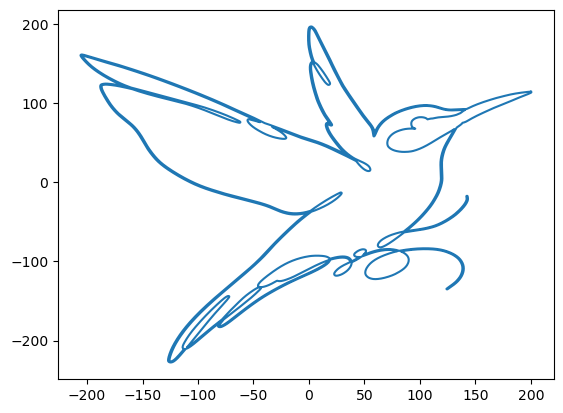

In [8]:
divs = 30
t = np.linspace(0, 1, divs)  # time periods within a single Bezier curve

x, y = np.array([]), np.array([])

start = (0, 0)
new_start = (0, 0)
set_start = False
linear_coordinates = []
bezier_coordinates = []
relative = True

for i in bezier_elements:
    if i[0] == 'M':
        set_start = True
    elif i[0] in ('C', 'c', 'L', 'l'):
        curve_type = i[0]
        if i[0] in ('C', 'L'):
            relative = False
        elif i[0] in ('c', 'l'):
            relative = True
    elif i[0] == 'z':
        pass  # go to start
    else:  # if a coordinate
        x_coord, y_coord = float(i[1]), float(i[2])
        if set_start:
           new_start = x_coord, y_coord
           set_start = False
        else:
            # based on the curve type consume the number and decide which p is that
            if curve_type in ('C', 'c'):
                if len(bezier_coordinates) < 3:
                    bezier_coordinates.append((x_coord, y_coord))
                if len(bezier_coordinates) == 3:
                    x_curve, y_curve, new_start = cubic_bezier_curve(
                        t, 
                        new_start, 
                        bezier_coordinates[0],
                        bezier_coordinates[1],
                        bezier_coordinates[2],
                        relative
                    )
                    bezier_coordinates = []
                    x = np.concatenate([x, x_curve])
                    y = np.concatenate([y, y_curve])

x = x - np.mean(x)
y = (y - np.mean(y)) * (-1)  # multiply by -1 in order to flip the image top to bottom

fig, ax = plt.subplots()
ax.plot(x, y)

## Make arrow objects

In [9]:
from matplotlib.patches import FancyArrow

class Arrow:
    """Arrow start and end are determined relative to the other arrows
    which are already placed on the plot."""
    def __init__(self, n, cn, period):
        self.cn = cn
        self.n = n
        self.val = cn # value of the Fourier series component
        self.start = complex  # placeholder to be filled, the start of the arrow in a 2-D space
        self.end = complex  # placeholder to be filled, the end of the arrow
        self.len = abs(self.val)
        self.period = period
    
    def update(self, t, new_start = 0):
        """Update the value at which the arrow points at the given t (time)
        and optionally the starting point."""
        self.val = self.cn*np.exp(1j*self.n*2*np.pi*t/self.period)
        self.start = new_start
        self.end = self.start + self.val


def sort_arrows_by_len(e):
    return e.len

In [10]:
len(x)

13050

In [11]:
len(x)/30

435.0

In [12]:
P = 435  # number of Bezier curves
#P = 11
t = np.linspace(0, P, len(x))  # period split by the number of data points

z = x + 1j*y  # the resulting complex number 

half_n = 50  # for addiset_UVC(U,V)tion of positive and negative n in the exponential form of the Fourier series

e_cn = lambda t,n,P: np.exp(-1j*2*np.pi*n*t/P)

arrows = []
i = 0

for n in range(-half_n, half_n+1):
    cn = np.sum(z * e_cn(t,n,P)/divs)/P
    arrows.append(Arrow(n,cn,P))
    i = i+1
    
arrows.sort(key = sort_arrows_by_len, reverse = True)

for n in range(len(arrows)):
    if n ==0:   
        arrows[n].start = 0
    else:
        arrows[n].start = arrows[n-1].end
    
    arrows[n].end = arrows[n].start + arrows[n].val

## Create animation with arrows

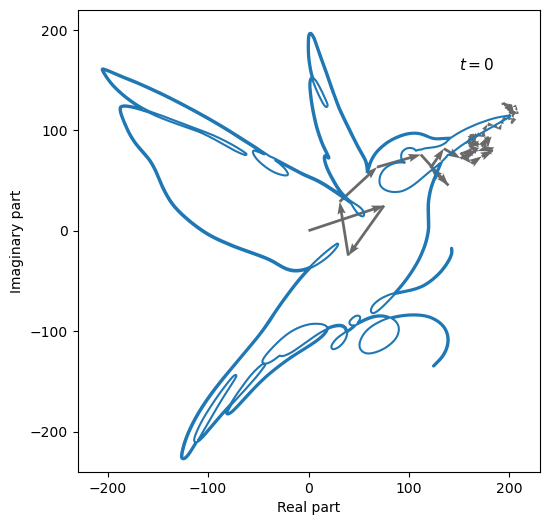

In [42]:
fig, ax = plt.subplots(figsize = (8,6))

x_covered_line = []
y_covered_line = []

def animate(t):

    xs = []
    ys = []
    us = []
    vs = []

    for n in range(len(arrows)):

        if n ==0:
            arrows[n].update(t=t)
        else:
            arrows[n].update(t=t, new_start=arrows[n-1].end)
            
        ar = arrows[n]
        xs.append(ar.start.real)
        ys.append(ar.start.imag)
        us.append(ar.val.real)
        vs.append(ar.val.imag)
        
        if n == len(arrows)-1:
            x_covered_line.append(ar.end.real)
            y_covered_line.append(ar.end.imag)
    
    ax.clear()
    ax.set_xlim(-230, 230)
    ax.set_ylim(-240, 220)
    ax.set_xlabel('Real part')
    ax.set_ylabel('Imaginary part')
    #ax.set_title('Complex Fourier Series of'+ ' ' + label +': N = {}'.format(str(N)))
    vectors = ax.quiver(xs, ys, us, vs, angles='xy', scale_units='xy', scale=1, color='dimgrey', headaxislength=4, headlength=4.5)
    approximated = ax.plot(x,y)
    approx = ax.plot(x_covered_line, y_covered_line, label = 'Fourier approx.')
    text_element = ax.text(s=f'$t = {round(t)}$', x=150, y=160, size=11)
    ax.set_aspect(1)
    return vectors, approximated, approx
    

ani = FuncAnimation(
    fig,
    animate,
    interval=100,
    blit=False,  # blitting can't be used with Figure artists
    frames=t[0::15],
    repeat_delay=100,
)

In [41]:
ani

In [43]:
ani.save('../../assets/images/optimization/fourier_series_complex_figure.gif');